In [1]:
## widen the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
from util import *
from models import *
from cfg import get_cfg
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm_normal
%matplotlib inline

In [3]:
d = 12
k = 7
M = 50000
N = 20
T = 25000
SEED = 4519
# 619 3019 1009 119 419 719 1319 4001 911 811 1109 4691

feature_bound = 1.
mapping_bound = 1.
param_bound = 1.

In [4]:
txt = """
2 3 5 7 11 13 17 19 23 29 31 37 41 43 47 53 59 61 67 71 73 79 83 89 97 101 103 107 109 113 127 131 137 139 149 151 157 163 167 173 179 181 191 193 197 199 211 223 227 229 233 239 241 251 257 263 269 271 277 281 283 293 307 311 313 317 331 337 347 349 353 359 367 373 379 383 389 397 401 409 419 421 431 433 439 443 449 457 461 463 467 479 487 491 499 503 509 521 523 541 547 557 563 569 571 577 587 593 599 601 607 613 617 619 631 641 643 647 653 659 661 673 677 683 691 701 709 719 727 733 739 743 751 757 761 769 773 787 797 809 811 821 823 827 829 839 853 857 859 863 877 881 883 887 907 911 919 929 937 941 947 953 967 971 977 983 991 997 1009 1013 1019 1021 1031 1033 1039 1049 1051 1061 1063 1069 1087 1091 1093 1097 1103 1109 1117 1123 1129 1151 1153 1163 1171 1181 1187 1193 1201 1213 1217 1223 1229 1231 1237 1249 1259 1277 1279 1283 1289 1291 1297 1301 1303 1307 1319 1321 1327 1361 1367 1373 1381 1399 1409 1423 1427 1429 1433 1439 1447 1451 1453 1459 1471 1481 1483 1487 1489 1493 1499 1511 1523 1531 1543 1549 1553 1559 1567 1571 1579 1583 1597 1601 1607 1609 1613 1619 1621 1627 1637 1657 1663 1667 1669 1693 1697 1699 1709 1721 1723 1733 1741 1747 1753 1759 1777 1783 1787 1789 1801 1811 1823 1831 1847 1861 1867 1871 1873 1877 1879 1889 1901 1907 1913 1931 1933 1949 1951 1973 1979 1987 1993 1997 1999 2003 2011 2017 2027 2029 2039 2053 2063 2069 2081 2083 2087 2089 2099 2111 2113 2129 2131 2137 2141 2143 2153 2161 2179 2203 2207 2213 2221 2237 2239 2243 2251 2267 2269 2273 2281 2287 2293 2297 2309 2311 2333 2339 2341 2347 2351 2357 2371 2377 2381 2383 2389 2393 2399 2411 2417 2423 2437 2441 2447 2459 2467 2473 2477 2503 2521 2531 2539 2543 2549 2551 2557 2579 2591 2593 2609 2617 2621 2633 2647 2657 2659 2663 2671 2677 2683 2687 2689 2693 2699 2707 2711 2713 2719 2729 2731 2741 2749 2753 2767 2777 2789 2791 2797 2801 2803 2819 2833 2837 2843 2851 2857 2861 2879 2887 2897 2903 2909 2917 2927 2939 2953 2957 2963 2969 2971 2999 3001 3011 3019 3023 3037 3041 3049 3061 3067 3079 3083 3089 3109 3119 3121 3137 3163 3167 3169 3181 3187 3191 3203 3209 3217 3221 3229 3251 3253 3257 3259 3271 3299 3301 3307 3313 3319 3323 3329 3331 3343 3347 3359 3361 3371 3373 3389 3391 3407 3413 3433 3449 3457 3461 3463 3467 3469 3491 3499 3511 3517 3527 3529 3533 3539 3541 3547 3557 3559 3571 3581 3583 3593 3607 3613 3617 3623 3631 3637 3643 3659 3671 3673 3677 3691 3697 3701 3709 3719 3727 3733 3739 3761 3767 3769 3779 3793 3797 3803 3821 3823 3833 3847 3851 3853 3863 3877 3881 3889 3907 3911 3917 3919 3923 3929 3931 3943 3947 3967 3989 4001 4003 4007 4013 4019 4021 4027 4049 4051 4057 4073 4079 4091 4093 4099 4111 4127 4129 4133 4139 4153 4157 4159 4177 4201 4211 4217 4219 4229 4231 4241 4243 4253 4259 4261 4271 4273 4283 4289 4297 4327 4337 4339 4349 4357 4363 4373 4391 4397 4409 4421 4423 4441 4447 4451 4457 4463 4481 4483 4493 4507 4513 4517 4519 4523 4547 4549 4561 4567 4583 4591 4597 4603 4621 4637 4639 4643 4649 4651 4657 4663 4673 4679 4691 4703 4721 4723 4729 4733 4751 4759 4783 4787 4789 4793 4799 4801 4813 4817 4831 4861 4871 4877 4889 4903 4909 4919 4931 4933 4937 4943 4951 4957 4967 4969 4973 4987 4993 4999
"""
seeds = [int(item) for item in txt.split()]
print(seeds)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997, 1009, 1013, 1019, 1021, 1031, 1033, 1039, 1049, 1051, 1061, 1063, 1069, 1087, 1091, 1093, 1097, 1103, 1109, 1117, 1123, 1129, 1151, 1153, 1163, 1171, 1181, 1187, 1193, 1201, 1213, 1217, 12

seed = 2
alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.37296, 0.33069]
alpha=0.01


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.25980, 0.26394]
alpha=0.05


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.33724, 0.32943]
alpha=0.1


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.37034, 0.32785]
alpha=0.3


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.31354, 0.37898]
alpha=0.5


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.35415, 0.27894]


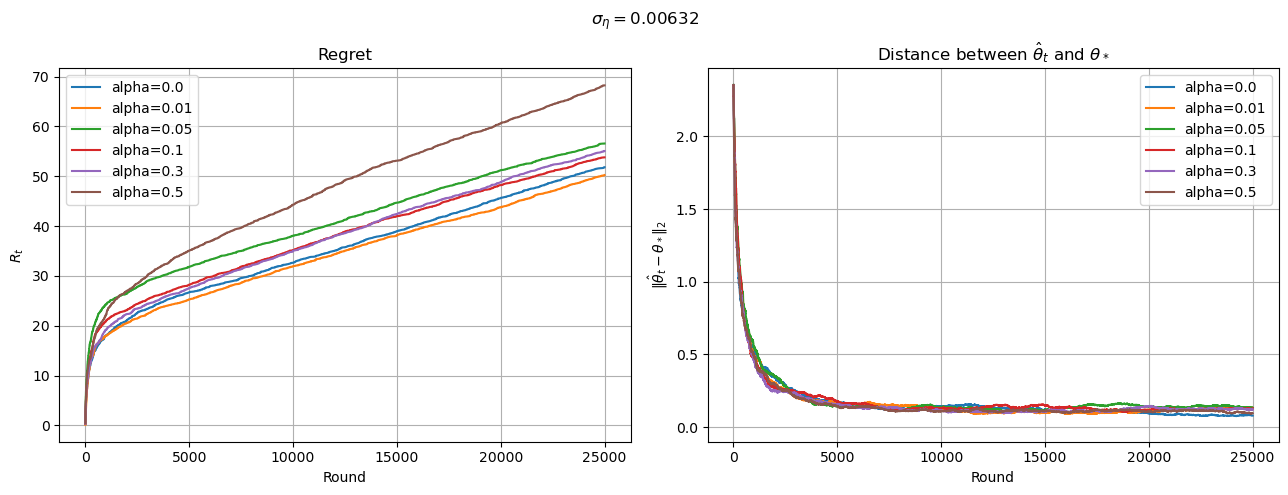

seed = 3
alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.20736, 0.35829]
alpha=0.01


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.23509, 0.25851]


KeyboardInterrupt: 

In [6]:
reward_std = 0.1
context_std = 1 / np.sqrt(T)
alphas = [0., 0.01, 0.05, 0.1, 0.3, 0.5]
trials = 1

for seed in seeds:
    print(f"seed = {seed}")
    Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, bound=feature_bound, bound_method="scaling", random_state=seed)
    A = mapping_generator(latent_dim=k, obs_dim=d, distribution="uniform", upper_bound=mapping_bound, random_state=((seed*13)//3))
    true_mu = param_generator(dimension=k, distribution="uniform", disjoint=True, bound=param_bound, random_state=((seed*13)//3)+1)
    B = left_pseudo_inverse(A)
    true_theta = B.T @ true_mu
    
    result = dict()
    for alpha in alphas:
        print(f"alpha={alpha}")
        regret_container = np.zeros(trials, dtype=object)
        error_container = np.zeros(trials, dtype=object)
        for trial in range(trials):
            regrets = np.zeros(T)
            errors = np.zeros(T)
            agent = LinUCB(d=d, alpha=alpha, lbda=1.)
            for t in tqdm(range(T)):
                seed_ = seed + (100000 * trial) + t + int(1000000*alpha)
                idx = np.random.choice(np.arange(M), size=N, replace=False)
                latent_set = Z[idx, :]

                ## sample the context noise and generate the observable feature
                context_noise = subgaussian_noise(distribution="gaussian", size=(N*d), std=context_std, random_state=seed_).reshape(N, d)
                action_set = latent_set @ A.T + context_noise

                ## clipping
                for i in range(N):
                    action = action_set[i, :]
                    if l2norm(action) > feature_bound:
                        action_set[i, :] *= (feature_bound / l2norm(action))

    #             ## scaling
    #             maxnorm = np.max([l2norm(action) for action in action_set])
    #             action_set *= (feature_bound / maxnorm)

                ## sample the reward noise and compute the reward
                reward_noise = subgaussian_noise(distribution="gaussian", size=N, std=reward_std, random_state=seed_+1)
                expected_reward = latent_set @ true_mu
                if t == 0:
                    print(f"Reward range: [{np.min(expected_reward):.5f}, {np.max(expected_reward):.5f}]")
                true_reward = expected_reward + reward_noise
                optimal_arm = np.argmax(expected_reward)
                optimal_reward = expected_reward[optimal_arm]

                ## choose the best action
                chosen_arm = agent.choose(action_set)
                chosen_reward = true_reward[chosen_arm]
                chosen_context = action_set[chosen_arm]

                ## compute the regret and the theta distances
                regrets[t] = optimal_reward - expected_reward[chosen_arm]
                errors[t] = l2norm(true_theta - agent.theta_hat)

                ## update the agent
                agent.update(x=chosen_context, r=chosen_reward)

            regret_container[trial] = np.cumsum(regrets)
            error_container[trial] = errors
        result[alpha] = (regret_container, error_container)
    
    NROWS, NCOLS = 1, 2
    title = r"$\sigma_\eta=$"
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(13, 5))

    for i in range(NROWS):
        for j in range(NCOLS):
            for key in result:
                item = result[key][j]
                ax[j].plot(np.mean(item, axis=0), label=f"alpha={key}")
                ax[j].set_xlabel("Round")
                if j == 0:
                    ax[j].set_ylabel(r"$R_t$")
                    ax[j].set_title("Regret")
                else:
                    ax[j].set_ylim(-0.1, None)
                    ax[j].set_ylabel(r"${\Vert \hat{\theta}_t - \theta_*\Vert}_2$")
                    ax[j].set_title(r"Distance between $\hat\theta_t$ and $\theta_*$")
                ax[j].grid(True)
                ax[j].legend()

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(f"{title}{context_std:.5f}")
    plt.show()

In [6]:
Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, bound=feature_bound, 
                    bound_method="scaling", random_state=SEED)
print(f"Shape of the latent feature sets: {Z.shape}")
print(f"The first feature: {Z[0]}")
print(f"Maximum norm: {np.max([l2norm(latent) for latent in Z]):.5f}")

Shape of the latent feature sets: (50000, 7)
The first feature: [-0.00392194 -0.11666667  0.0533275   0.02859768  0.10037692 -0.09084898
  0.15682105]
Maximum norm: 1.00000


In [7]:
A = mapping_generator(latent_dim=k, obs_dim=d, distribution="uniform", upper_bound=mapping_bound, random_state=SEED)
print(f"Shape of the mapping: {A.shape}")
print(A)
print(f"Maximum singular value: {np.linalg.norm(A, 2):.5f}")
print(f"Singular values of A: {np.linalg.svd(A)[1]}")

Shape of the mapping: (10, 7)
[[-0.31657186 -0.01064208  0.16331606  0.30454353 -0.20399528  0.22538963
  -0.13522688]
 [ 0.08073808  0.22211348  0.24119891 -0.14110774  0.31087262  0.30032654
  -0.2632702 ]
 [-0.09413698  0.05055741  0.24335455  0.08170076  0.34556612 -0.0110382
  -0.09066764]
 [-0.03916734  0.33802153  0.32815182 -0.33576982  0.24361215  0.17489764
   0.15026356]
 [-0.1762739   0.09790998  0.31518954  0.20249169  0.15185948 -0.018907
  -0.24195778]
 [-0.08381706 -0.30814147  0.27936042  0.0942056  -0.05584342  0.17828247
  -0.06610867]
 [ 0.31271101  0.30072142 -0.01709508  0.2369252   0.05006943 -0.11702055
   0.24601339]
 [-0.27007748  0.10269309 -0.23930862  0.01747763  0.311682    0.00690835
  -0.02785168]
 [ 0.3155526  -0.277108    0.17931111 -0.25357482 -0.33523574  0.19840606
   0.22488268]
 [ 0.27649967 -0.21293691  0.12925054  0.0277112   0.06369505  0.06210135
  -0.1956729 ]]
Maximum singular value: 1.00000
Singular values of A: [1.         0.8473767  0.813

In [8]:
B = left_pseudo_inverse(A)
print(f"Shape of B: {B.shape}")
print(B)
print(f"Maximum singular value: {np.linalg.norm(B, 2):.5f}")
print(f"Singular values of A: {np.linalg.svd(B)[1]}")

Shape of B: (7, 10)
[[-0.41996324  0.69355987 -0.1762755  -0.46281428 -0.24094511 -0.25192143
   0.86972724 -0.37795648  0.2668679   0.9203779 ]
 [ 0.51705243  0.69196694 -0.81262342  0.47277187  0.41819033 -1.23859308
   0.42971486 -0.72476199 -0.48835042 -0.56521565]
 [-0.16064589 -0.54808381  0.66279858  0.75484797  1.13908774  0.34854256
  -0.07554623 -1.1209476   0.20597291 -0.10399323]
 [ 0.91066718 -0.0841182   0.39099136 -0.71672276 -0.11078345  0.68945194
   1.46277681  0.55867508 -0.12546382  0.27170718]
 [-0.69118462  0.07736969  1.19061925  0.07215147 -0.49620517  0.85140684
   0.46852635  1.44005214 -0.07299895  0.50341006]
 [ 1.42618415  1.45232742 -0.43316914 -0.06670282 -1.44160433  0.74022082
   0.67175919  1.48647264  0.73087135  0.2153192 ]
 [ 0.04759613 -1.07304833  0.80741057  0.70840502 -0.8471534   1.08319023
   1.15502461  1.04808642  0.78325217 -0.6450852 ]]
Maximum singular value: 4.28564
Singular values of A: [4.28564434 3.11847279 2.00171923 1.82834461 1.228

In [9]:
true_mu = param_generator(dimension=k, distribution="uniform", disjoint=True, bound=param_bound, random_state=SEED+1)
print(f"True mu: {true_mu}")
print(f"Norm of the true mu: {l2norm(true_mu)}")

True mu: [ 5.60067690e-01  4.20507462e-01  4.33533405e-01 -1.32306448e-04
  2.93454928e-01  4.85042589e-01  1.28186533e-02]
Norm of the true mu: 1.0


In [10]:
true_theta = B.T @ true_mu
print(f"True theta: {true_theta}")
print(f"Norm of the true theta: {l2norm(true_theta)}")

True theta: [ 0.40198936  1.15520635 -0.00350931  0.26484371 -0.32095889  0.11185614
  1.11298813  0.15453681  0.3765439   0.47657406]
Norm of the true theta: 1.8202500960141776


In [11]:
reward_std = 0.1
context_std = 0.
alphas = [0., 0.25, 0.5, 0.75, 1.0]
trials = 1

In [12]:
result = dict()
for alpha in alphas:
    print(f"alpha={alpha}")
    regret_container = np.zeros(trials, dtype=object)
    error_container = np.zeros(trials, dtype=object)
    for trial in range(trials):
        regrets = np.zeros(T)
        errors = np.zeros(T)
        agent = LinUCB(d=d, alpha=alpha, lbda=1.)
        for t in tqdm(range(T)):
            seed = SEED + (100000 * trial) + t + int(10000000*alpha)
            idx = np.random.choice(np.arange(M), size=N, replace=False)
            latent_set = Z[idx, :]
            
            ## sample the context noise and generate the observable feature
            context_noise = subgaussian_noise(distribution="gaussian", size=(N*d), std=context_std, random_state=seed).reshape(N, d)
            action_set = latent_set @ A.T + context_noise
            
            ## clipping
            for i in range(N):
                action = action_set[i, :]
                if l2norm(action) > feature_bound:
                    action_set[i, :] *= (feature_bound / l2norm(action))

#             ## scaling
#             maxnorm = np.max([l2norm(action) for action in action_set])
#             action_set *= (feature_bound / maxnorm)
            
            ## sample the reward noise and compute the reward
            reward_noise = subgaussian_noise(distribution="gaussian", size=N, std=reward_std, random_state=seed)
            expected_reward = latent_set @ true_mu
            if t == 0:
                print(f"Reward range: [{np.min(expected_reward):.5f}, {np.max(expected_reward):.5f}]")
            true_reward = expected_reward + reward_noise
            optimal_arm = np.argmax(expected_reward)
            optimal_reward = expected_reward[optimal_arm]
            
            ## choose the best action
            chosen_arm = agent.choose(action_set)
            chosen_reward = true_reward[chosen_arm]
            chosen_context = action_set[chosen_arm]
            
            ## compute the regret and the theta distances
            regrets[t] = optimal_reward - expected_reward[chosen_arm]
            errors[t] = l2norm(true_theta - agent.theta_hat)
            
            ## update the agent
            agent.update(x=chosen_context, r=chosen_reward)
        
        regret_container[trial] = np.cumsum(regrets)
        error_container[trial] = errors
    result[alpha] = (regret_container, error_container)

alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.26063, 0.25172]
alpha=0.25


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.40718, 0.24305]
alpha=0.5


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.27461, 0.35473]
alpha=0.75


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.21672, 0.31968]
alpha=1.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.31226, 0.35362]


/home/sungwoopark/anaconda3/envs/main/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sungwoopark/anaconda3/envs/main/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


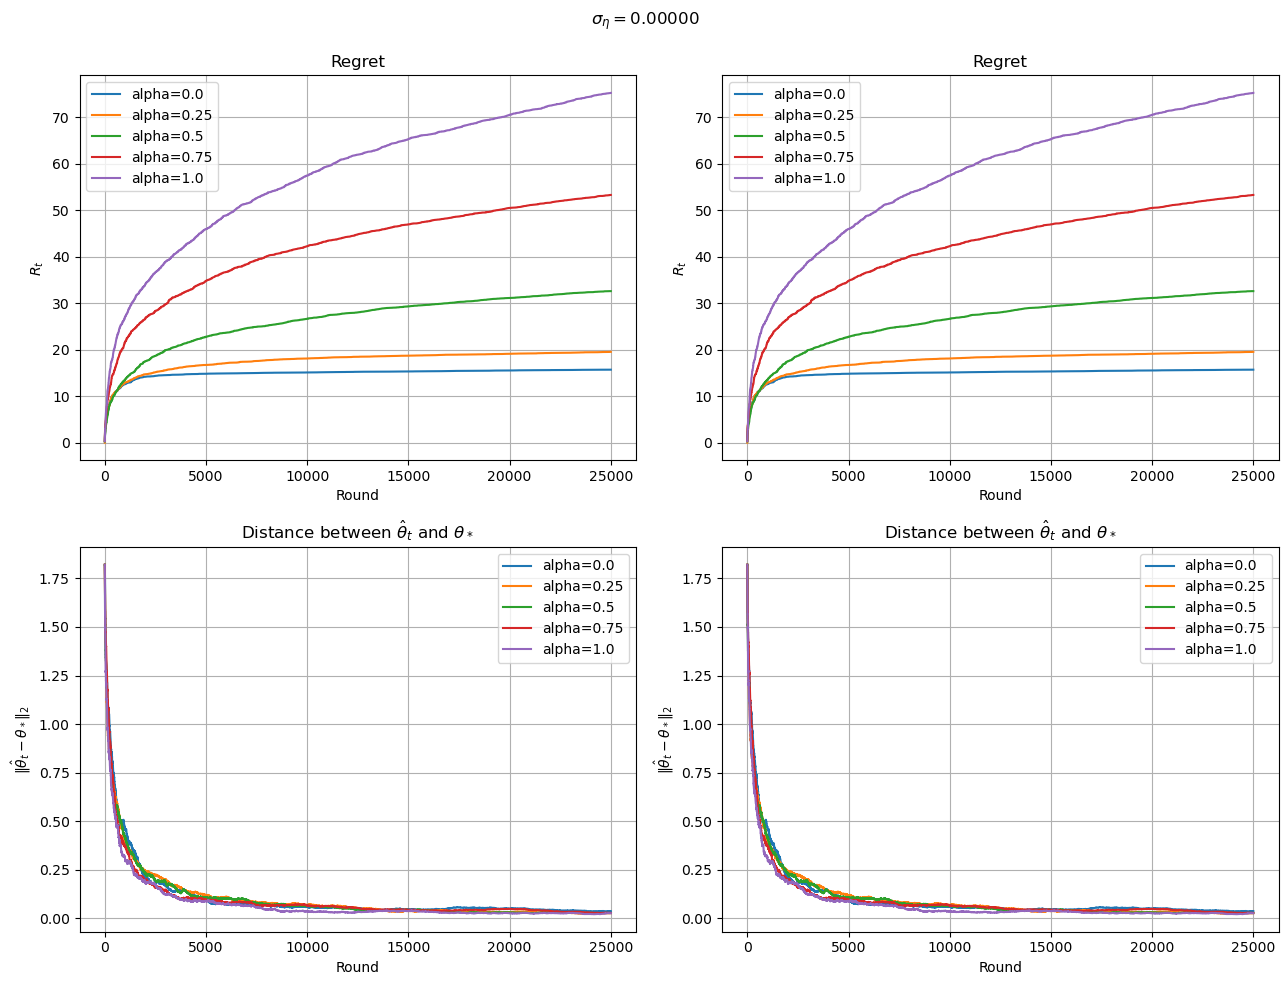

In [13]:
NROWS = NCOLS = 2
title = r"$\sigma_\eta=$"
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(13, 10))

for i in range(NROWS):
    for j in range(NCOLS):
        for key in result:
            item = result[key][i]
            if j == 0:
                ax[i][j].plot(np.mean(item, axis=0), label=f"alpha={key}")
            else:
                mean = np.mean(item, axis=0)
                std = np.std(item, axis=0, ddof=1)
                ax[i][j].plot(mean, label=f"alpha={key}")
                ax[i][j].fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
            ax[i][j].set_xlabel("Round")
            if i == 0:
                ax[i][j].set_ylabel(r"$R_t$")
                ax[i][j].set_title("Regret")
            else:
                ax[i][j].set_ylabel(r"${\Vert \hat{\theta}_t - \theta_*\Vert}_2$")
                ax[i][j].set_title(r"Distance between $\hat\theta_t$ and $\theta_*$")
            ax[i][j].grid(True)
            ax[i][j].legend()

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle(f"{title}{context_std:.5f}")
fig.show()